# Investment Portfolio Optimization 
In this notebook I do two things.
The first aim is to simulate random portfolios of four major stocks and to find optimal portfolios in terms of risk and Sharpe ratio. 
The second aim is to simulate random portfolios of correlated and uncorrelated stock and to see how portfolio returns are impacted.

## Portfolio of four major stock

In [1]:
# Importing libraries

import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import quandl
import scipy.optimize as sco
import pyfolio as pf
plt.style.use('fivethirtyeight')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/Users/alexandergeiger/opt/anaconda3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
# Importing data for four major stocks from quandl

quandl.ApiConfig.api_key = 'is9J6Gdep3c_XZpxQu8h'
stocks = ['AAPL','AMZN','GOOGL','FB']
data = quandl.get_table('WIKI/PRICES', ticker = stocks,
                        qopts = { 'columns': ['date', 'ticker', 'adj_close'] },
                        date = { 'gte': '2015-1-1', 'lte': '2018-3-26' }, paginate=True)
data.head()

,date,ticker,adj_close
None,,,
0,2018-03-26,GOOGL,1054.09
1,2018-03-23,GOOGL,1026.55
2,2018-03-22,GOOGL,1053.15
3,2018-03-21,GOOGL,1094.00
4,2018-03-20,GOOGL,1095.80


In [3]:
# Transform the dataframe into a more handy format

df = data.set_index ('date')
table = df.pivot(columns = 'ticker')
columns = table.columns.get_level_values(1)
table.columns = columns
table.head()

ticker,AAPL,AMZN,FB,GOOGL
date,,,,
2015-01-02,103.863957,308.52,78.450,529.55
2015-01-05,100.937944,302.19,77.190,519.46
2015-01-06,100.947444,295.29,76.150,506.64
2015-01-07,102.362951,298.42,76.150,505.15
2015-01-08,106.295968,300.46,78.175,506.91


ticker      AAPL      AMZN        FB     GOOGL
ticker                                        
AAPL    0.000213  0.000104  0.000105  0.000095
AMZN    0.000104  0.000325  0.000153  0.000153
FB      0.000105  0.000153  0.000247  0.000140
GOOGL   0.000095  0.000153  0.000140  0.000206


ticker
AAPL     0.000734
AMZN     0.002156
FB       0.001002
GOOGL    0.000950
dtype: float64

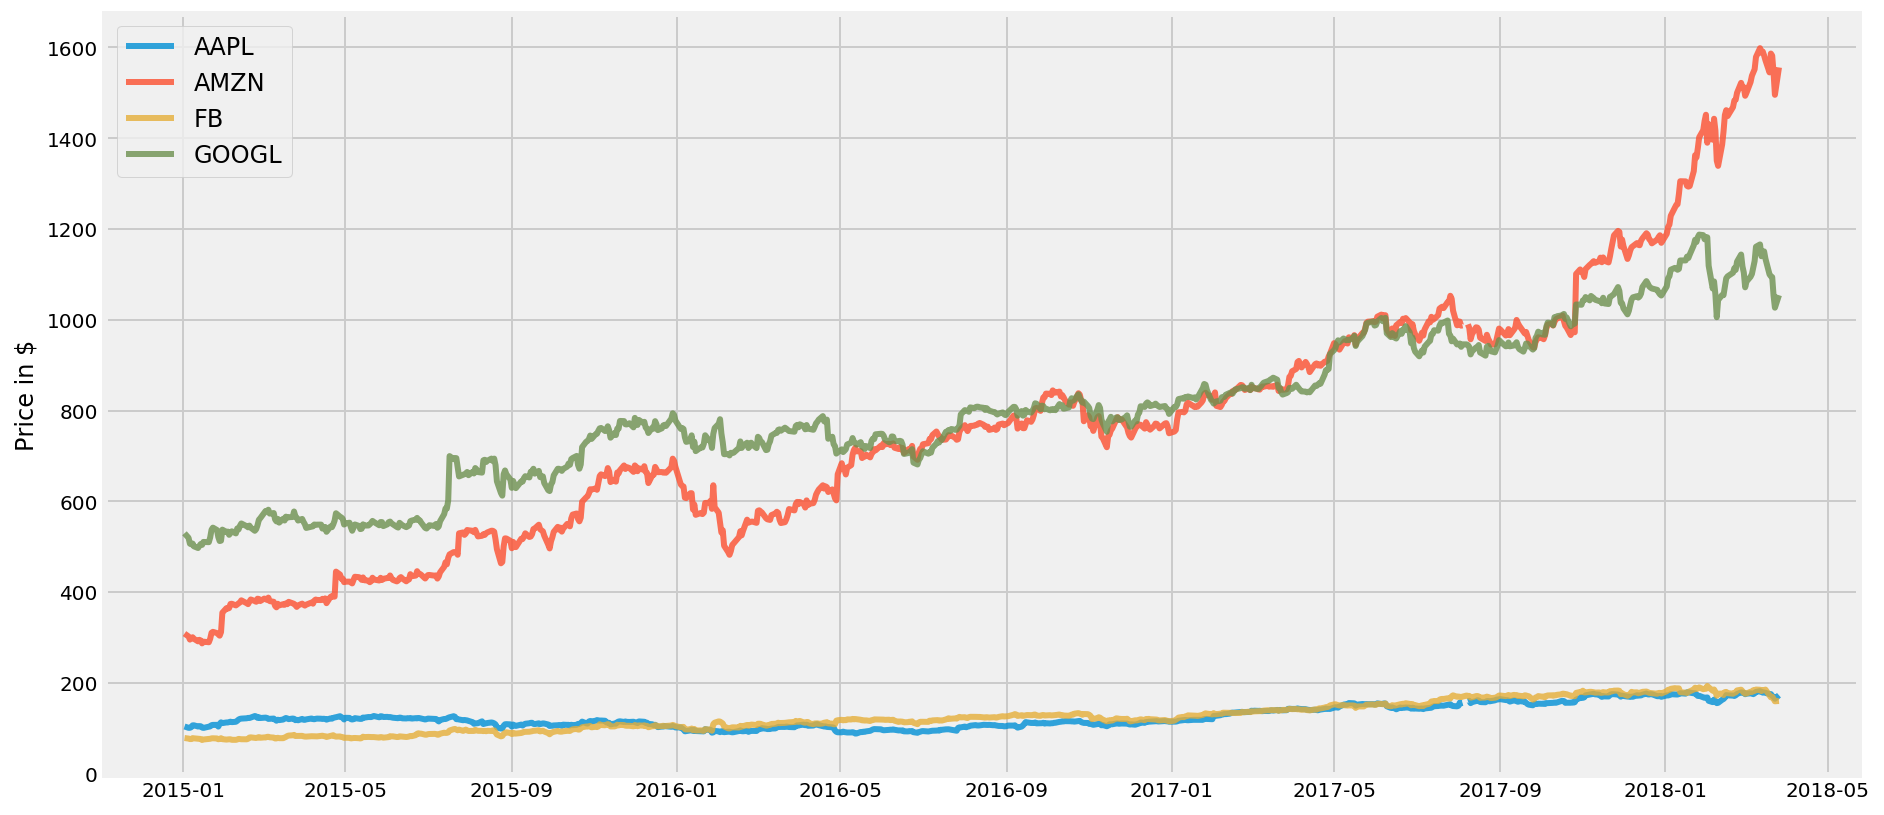

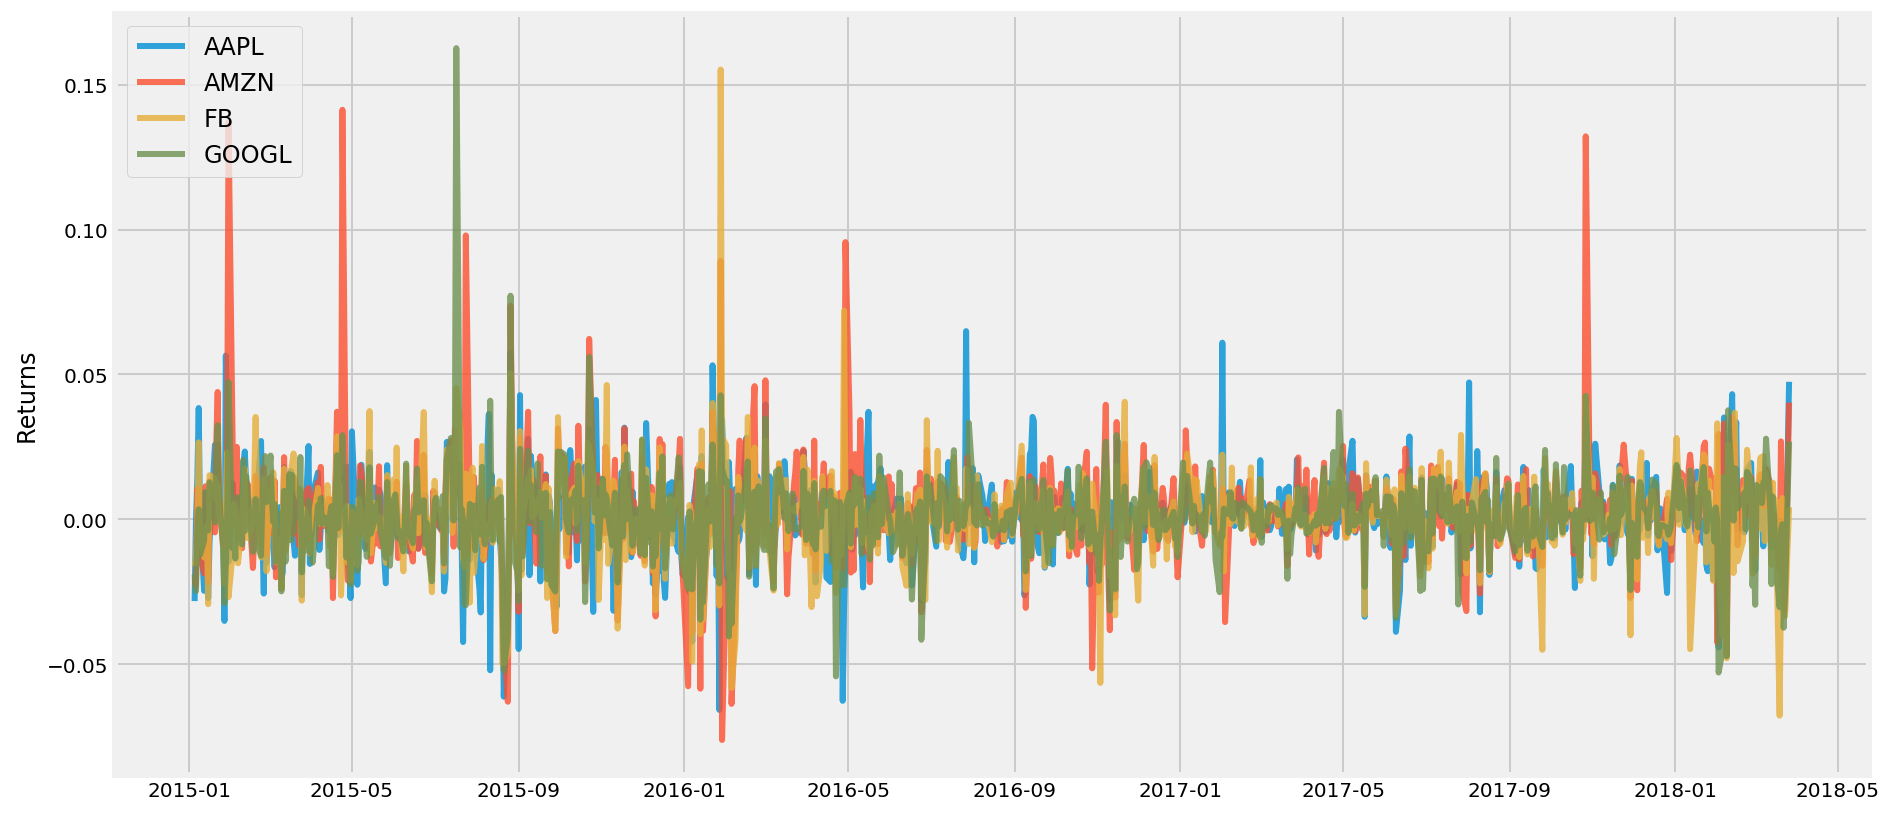

In [4]:
# Plot the prices of the stocks

plt.figure(figsize=(14, 7))
for c in table.columns:
    plt.plot(table.index, table[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('Price in $')

# Plot the returns of the stocks

returns = table.pct_change()
returns.head()
plt.figure(figsize=(14, 7))
for c in returns.columns:
    plt.plot(returns.index, returns[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('Returns')

# Mean returns

mean_returns = returns.mean()
cov_matrix = returns.cov()
print(cov_matrix)
mean_returns.head()

### Simulation of portfolios

In [14]:

#Number of portfolios
num_portfolios = 1000

#Array to hold the results: the first 3 elements are reserved for the portfolio values, the other 4 for the single stocks
results = np.zeros((3+4,num_portfolios))


#Loop over the porfolios
for i in range(num_portfolios):
    #Select random weights for portfolio holdings
    weights = np.random.random(4)
    #Rebalance weights to sum to 1
    weights = weights/ np.sum(weights)
    
    #Calculate portfolio return and volatility for 252 trading days
    portfolio_return = np.sum(mean_returns * weights) * 252
    portfolio_std_dev = np.sqrt(np.dot(weights.T,np.dot(cov_matrix, weights))) * np.sqrt(252)
    
    #Store results in results array
    results[0,i] = portfolio_return
    results[1,i] = portfolio_std_dev
    #Store Sharpe Ratio without risk free rate for the sake of simplicity
    results[2,i] = results[0,i] / results[1,i]
    
    for j in range(len(weights)):
        results[j+3,i] = weights[j]

#Convert results array to Pandas DataFrame
results_frame = pd.DataFrame(results.T,columns=['Returns','Volatility','Sharpe Ratio',stocks[0],stocks[1],stocks[2],stocks[3]])
results_frame.head()

,Returns,Volatility,Sharpe Ratio,AAPL,AMZN,GOOGL,FB
0,0.344704,0.215708,1.598008,0.000552,0.333891,0.293059,0.372498
1,0.322139,0.200288,1.608376,0.310916,0.318609,0.216273,0.154203
2,0.292411,0.201840,1.448726,0.130039,0.183639,0.325009,0.361312
3,0.238177,0.192065,1.240086,0.422725,0.060986,0.247034,0.269255
4,0.303473,0.196569,1.543847,0.291335,0.255515,0.172500,0.280650


### Find and plot optimal portfolios

Maximum Sharpe Ratio Portfolio:
 Returns         0.473940
Volatility      0.251922
Sharpe Ratio    1.881296
AAPL            0.094175
AMZN            0.783510
GOOGL           0.119644
FB              0.002672
Name: 196, dtype: float64
Minimum Risk Portfolio:
 Returns         0.240161
Volatility      0.191444
Sharpe Ratio    1.254469
AAPL            0.398276
AMZN            0.065071
GOOGL           0.201445
FB              0.335208
Name: 271, dtype: float64


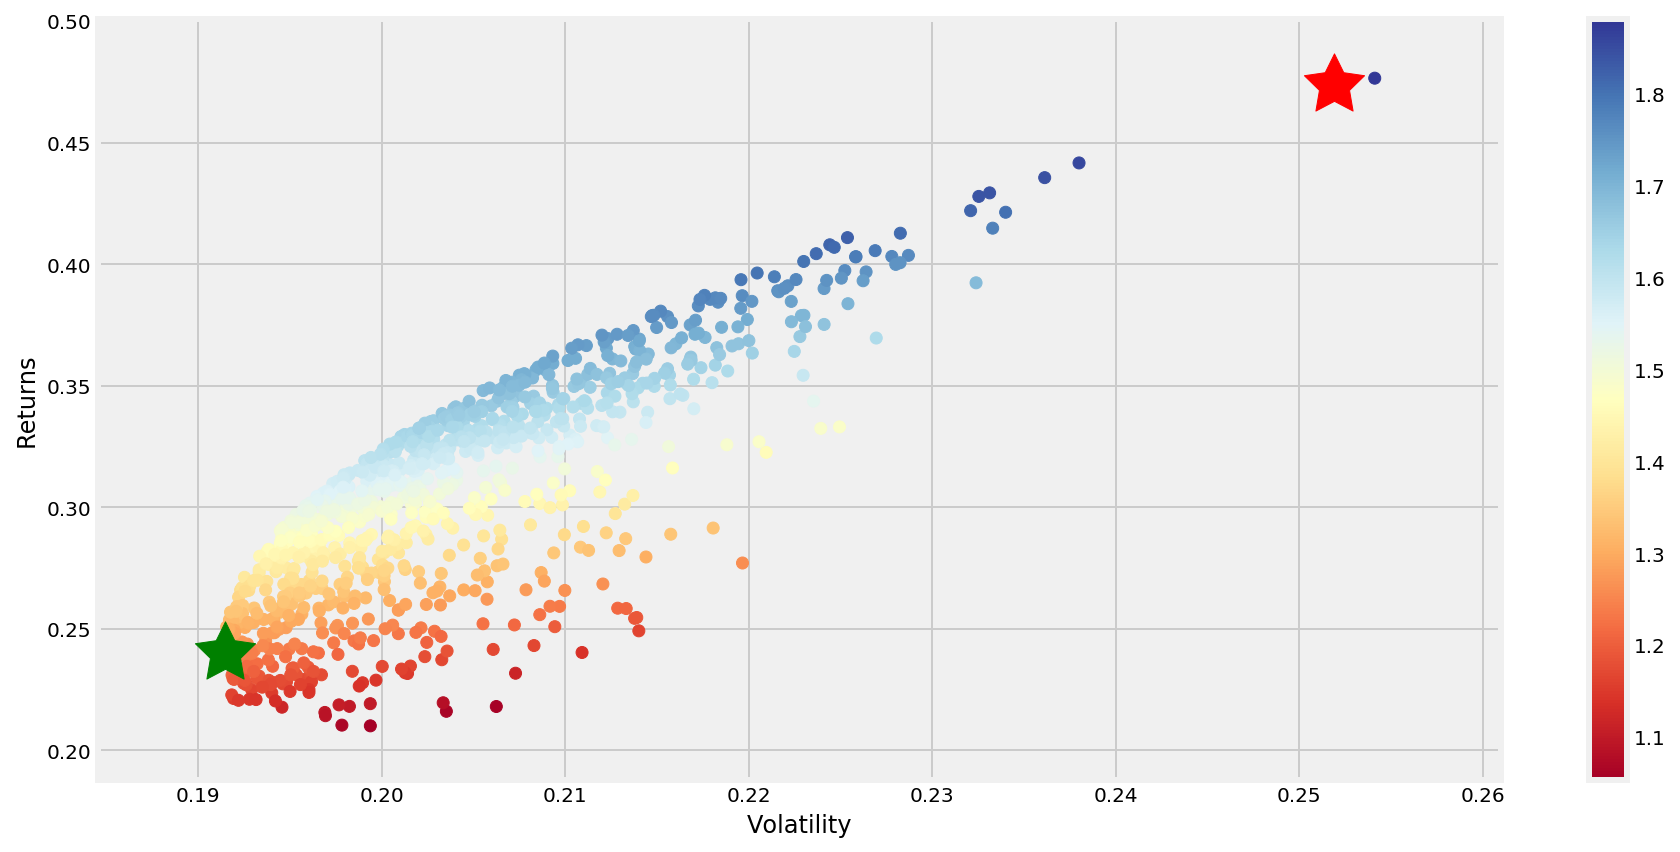

In [15]:
#Locate the position of the portfolio with the highest Sharpe Ratio
max_sharpe_port = results_frame.iloc[results_frame['Sharpe Ratio'].idxmax()]

#Locate the positon of the portfolio with the minimum standard deviation
min_vol_port = results_frame.iloc[results_frame['Volatility'].idxmin()]

#Create scatter plot coloured by Sharpe Ratio
plt.figure(figsize=(14, 7))
plt.scatter(results_frame['Volatility'],results_frame['Returns'],c=results_frame['Sharpe Ratio'],cmap='RdYlBu')
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.colorbar()

#Plot red star to highlight position of portfolio with highest Sharpe Ratio
plt.scatter(max_sharpe_port[1],max_sharpe_port[0],marker=(5,1,0),color='r',s=1000)
#Plot green star to highlight position of minimum variance portfolio
plt.scatter(min_vol_port[1],min_vol_port[0],marker=(5,1,0),color='g',s=1000)

#Print out the performance for optimal portfolios
print('Maximum Sharpe Ratio Portfolio:\n', max_sharpe_port)
print('Minimum Risk Portfolio:\n', min_vol_port)

## Simulation of portfolios of correlated and uncorrelated stocks 

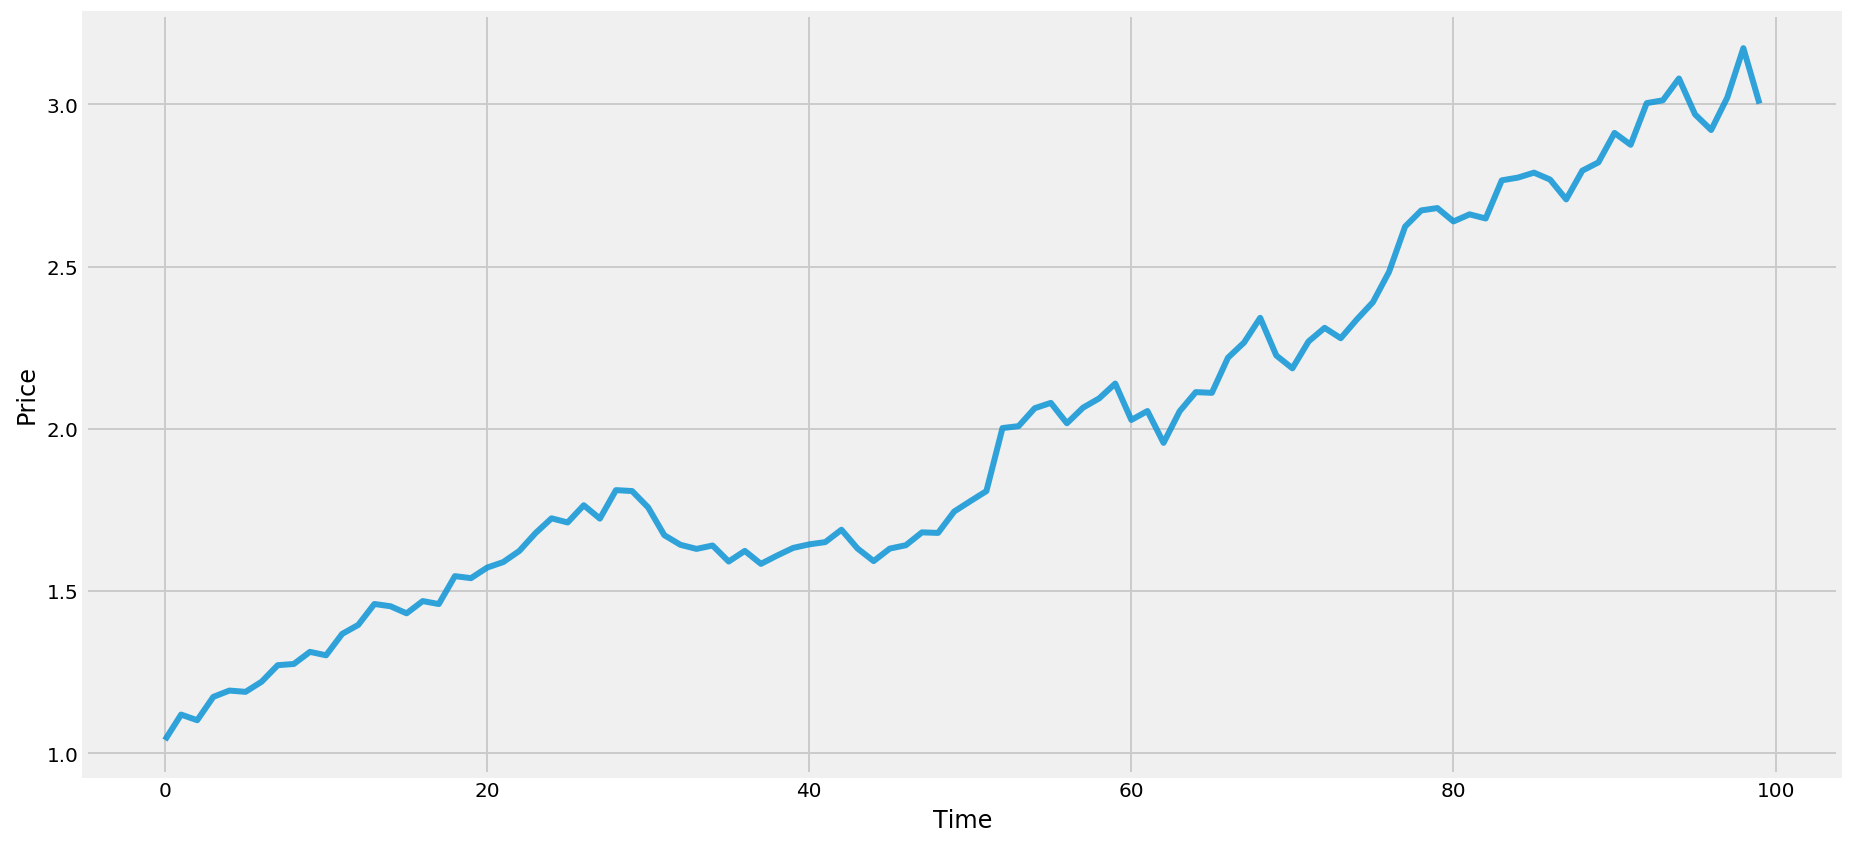

In [7]:
# Simulate price movement of a stock
returns_1 = np.random.normal(1.01, 0.03, 100)
price_1 = np.cumprod(returns_1)
plt.figure(figsize=(14, 7))
plt.plot(price_1, lw=3, alpha=0.8,label=c)
plt.xlabel('Time')
plt.ylabel('Price');

### Correlated Stocks

Mean Return: 1.00884929877689
Volatility: 0.03191834687021352
Sharpe Ratio: 31.60719140245816


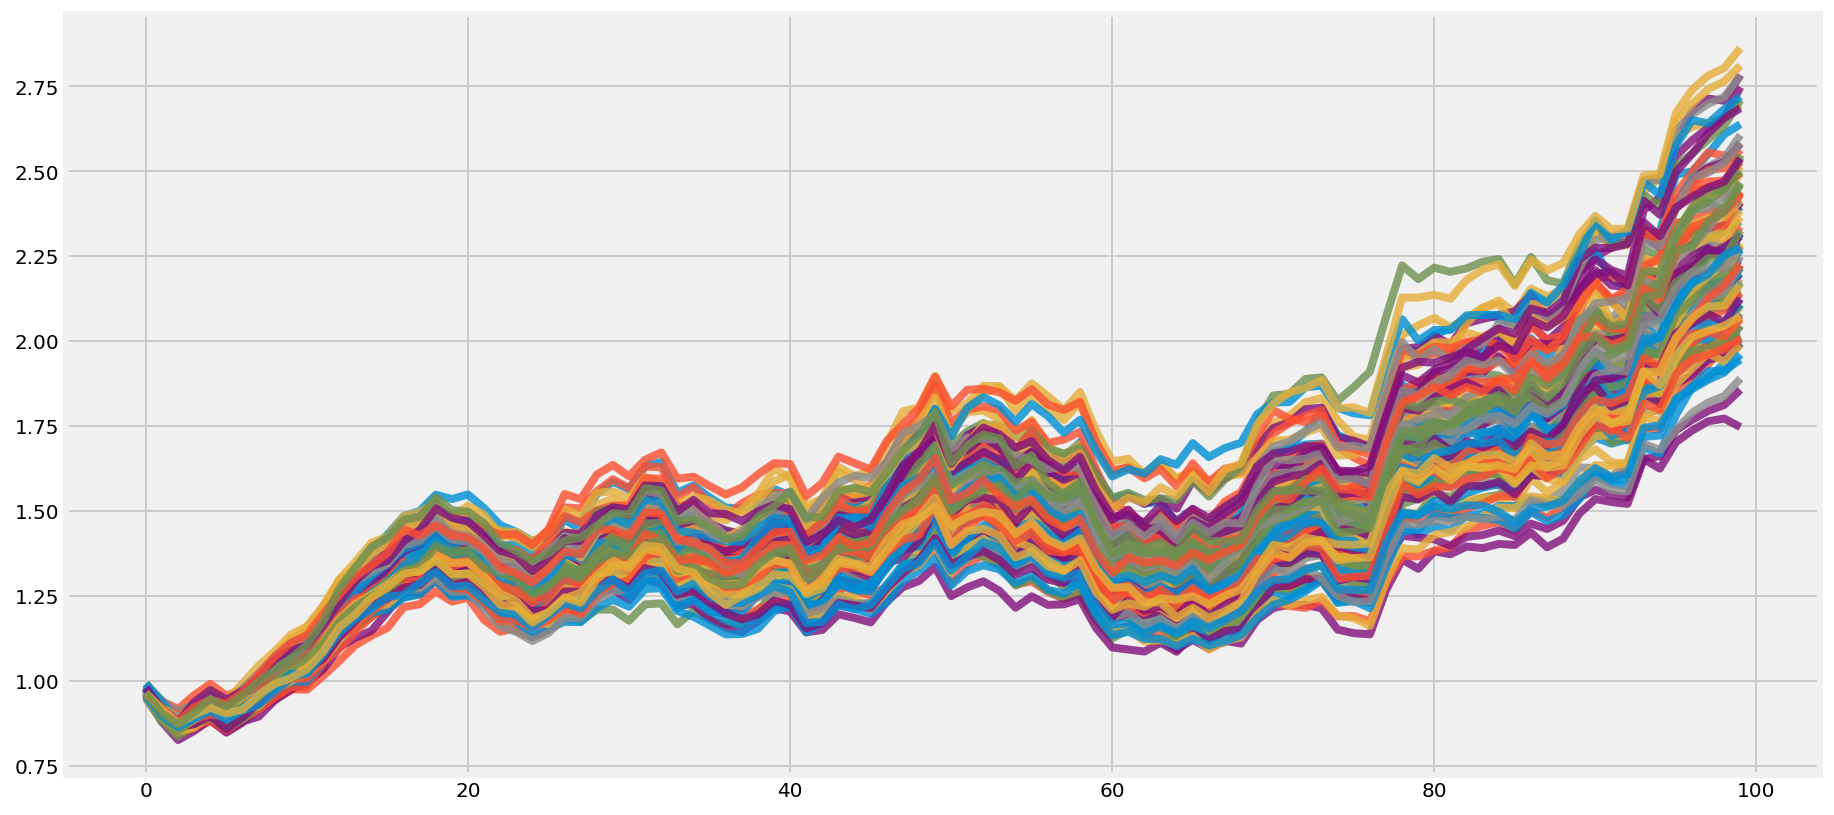

In [8]:
# Simulate a portfolio of 10 correlated stocks with equal weights
# Number of stocks
N = 100
# Number of trading days
D = 100

# Create arrays with zeros
returns_2 = np.zeros((N, D))
price_2 = np.zeros((N, D))
# First stock
returns_2[0] = np.random.normal(1.01, 0.03, D)
returns_st = returns_2[0]
price_2[0] = np.cumprod(returns_st)
plt.figure(figsize=(14, 7))
plt.plot(price_2[0], lw=3, alpha=0.8,label=c)

# Now loop over the entire portfolio

for i in range(1,N):
    returns_2[i] = returns_st + np.random.normal(0.001, 0.01, D)
    price_2[i] = np.cumprod(returns_2[i])
    plt.plot(price_2[i], alpha=0.8)

mean_returns_2 = np.mean(returns_2, axis=0)
returns_std_2 = np.std(mean_returns_2)
print('Mean Return:', np.mean(mean_returns_2))
print('Volatility:', returns_std_2)
print('Sharpe Ratio:', np.mean(mean_returns_2)/returns_std_2)





### Uncorrelated Stocks

Mean Return: 1.0097591341885823
Volatility: 0.0031921977174887033
Sharpe Ratio: 316.32098746783083


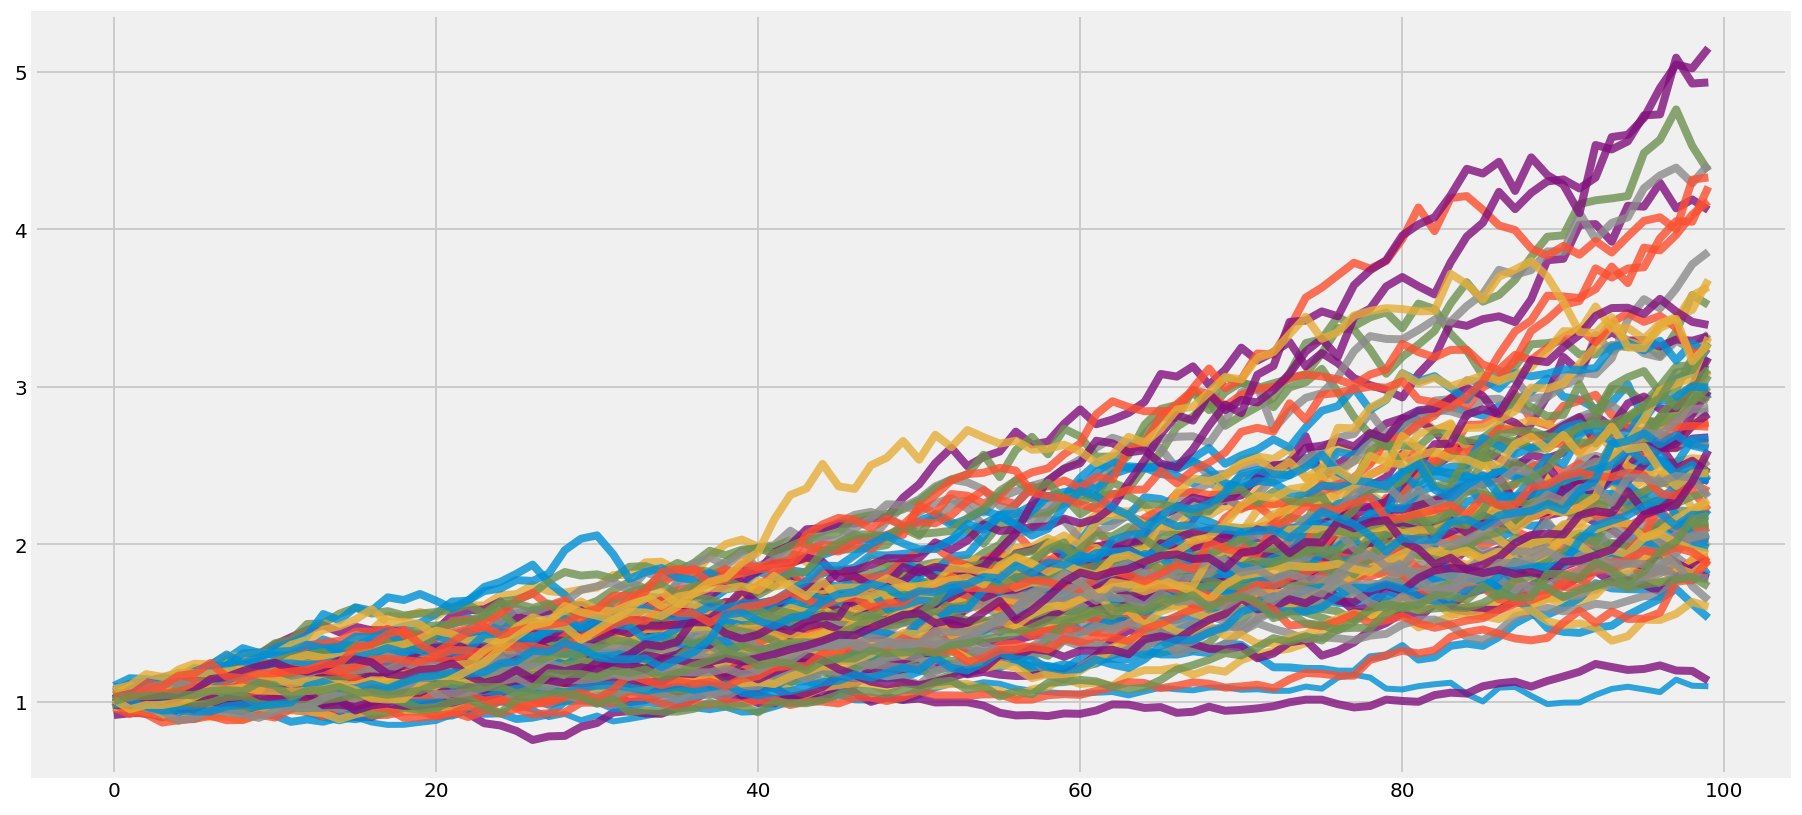

In [9]:
# Simulate a portfolio of 10 uncorrelated stocks with equal weights
# Number of stocks
N = 100
# Number of trading days
D = 100

# Create arrays with zeros
returns_3 = np.zeros((N, D))
price_3 = np.zeros((N, D))

# First stock
returns_3[0] = np.random.normal(1.01, 0.03, D)
returns_st = returns_3[0]
price_3[0] = np.cumprod(returns_st)
plt.figure(figsize=(14, 7))
plt.plot(price_3[0], lw=3, alpha=0.8,label=c)

# Now loop over the entire portfolio

for i in range(1,N):
    returns_3[i] = np.random.normal(01.01, 0.03, D)
    price_3[i] = np.cumprod(returns_3[i])
    plt.plot(price_3[i], alpha=0.8)
    
mean_returns_3 = np.mean(returns_3, axis=0)
returns_std_3 = np.std(mean_returns_3)
print('Mean Return:', np.mean(mean_returns_3))
print('Volatility:', returns_std_3)
print('Sharpe Ratio:', np.mean(mean_returns_3)/returns_std_3)
    

### Impact of portfolio size on the volatility
As it can be seen from the graph below the volatility of a portfolio of uncorrelated stocks decreases with an increasing number of stocks. However, the returns do not decrease. 

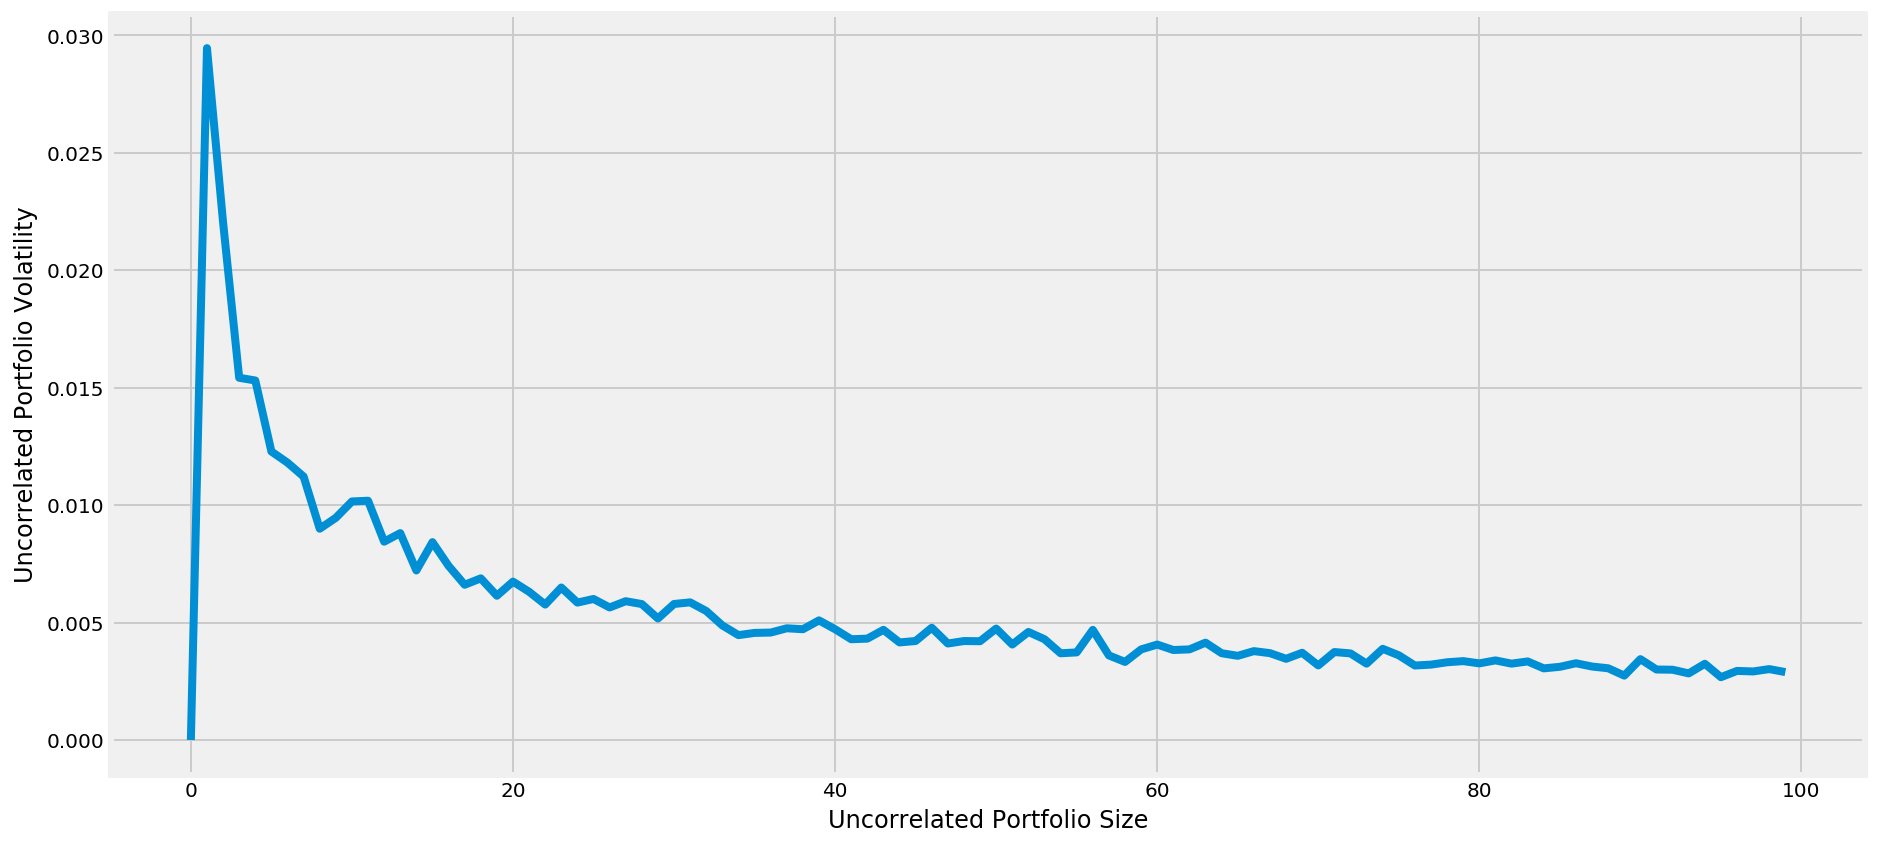

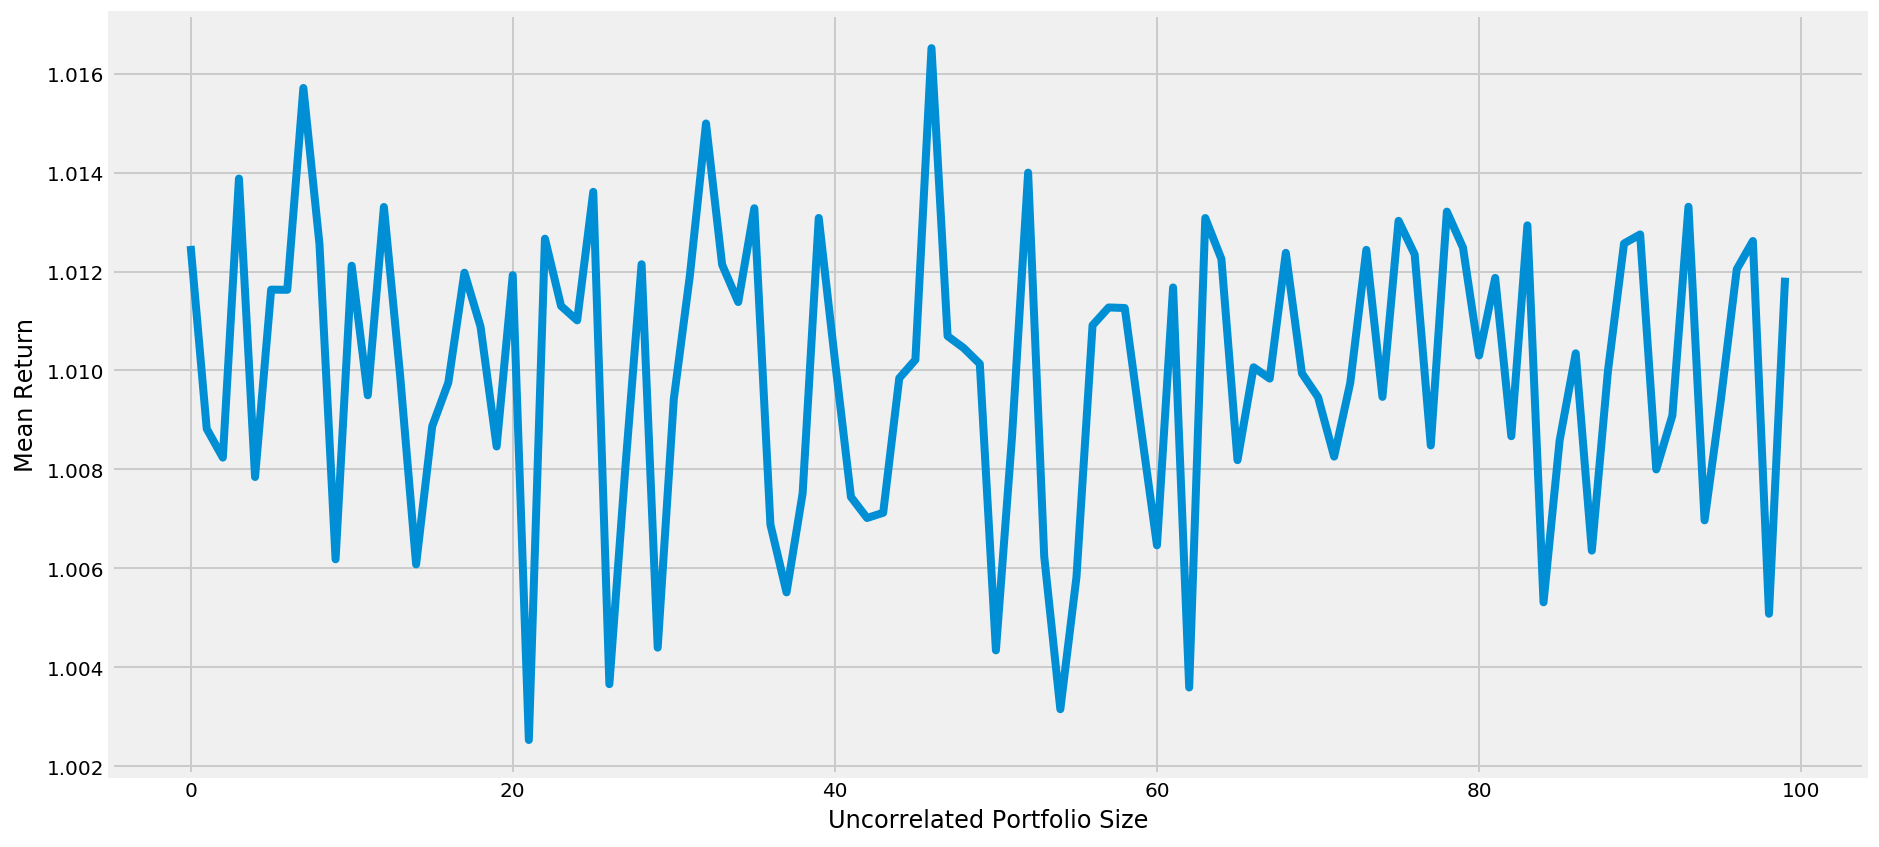

In [10]:
# 
# Number of stocks
N = 100
# Number of trading days
D = 100

returns_4 = np.zeros((D,1))

for j in range(1,N):

    # Create arrays with zeros
    returns_3 = np.zeros((j, D))
    price_3 = np.zeros((j, D))

    # First stock
    returns_3[0] = np.random.normal(1.01, 0.03, D)
    returns_st = returns_3[0]
    price_3[0] = np.cumprod(returns_st)
    
    # Now loop over the entire portfolio
    for i in range(1,j):
        returns_3[i] = np.random.normal(01.01, 0.03, D)
        price_3[i] = np.cumprod(returns_3[i])
        
    mean_returns_4 = np.mean(returns_3, axis=0)
    returns_4[j] = np.std(mean_returns_4)
    

plt.figure(figsize=(14, 7))
plt.plot(returns_4)
plt.xlabel('Uncorrelated Portfolio Size')
plt.ylabel('Uncorrelated Portfolio Volatility'); 

plt.figure(figsize=(14, 7))
plt.plot(mean_returns_4)
plt.xlabel('Uncorrelated Portfolio Size')
plt.ylabel('Mean Return'); 
    